In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import json
from sklearn.preprocessing import MinMaxScaler
from math import pi

from Tools import Tools4DataExtraction as T4DE

In [2]:
D4NN= T4DE.Get_Data4NN()
D4NN= D4NN.iloc[:-1]

Memoria usada antes: 627.39 MB
Memoria usada después: 121.90 MB
Reducción: 80.6%


In [3]:
D4NN.columns

Index(['FECHA_CORRIDA', 'HORA_SALIDA_ORIGEN_CORRIDA', 'TIPO_PASAJERO',
       'PAGO_METODO', 'PORCENT_PROMO', 'BOLETOS_VEND', 'AÑO', 'DIF_TARIF',
       'CLASE_SERVICIO', 'ORIGEN', 'DESTINO', 'MES', 'KMS_TRAMO',
       'OCUPACION_TRAMO', 'CAPACIDAD_ASIENTOS_TRAMO', 'HORAS_ANTICIPACION',
       'DISPONIBILIDAD_TRAMO', 'NOMBRE_DIA_CORRIDA', 'VENTA'],
      dtype='object')

In [4]:
def HourCorrection(df):
    D4NN=df.copy()
    # 1. Convertir a string (por si tiene tipo 'category' u 'object')
    D4NN['HORA_SALIDA_ORIGEN_CORRIDA'] = D4NN['HORA_SALIDA_ORIGEN_CORRIDA'].astype(str)
    
    # 2. Limpiar repeticiones dentro del texto, como "11:00:0011:00:00"
    # Explicación: busca repeticiones consecutivas y se queda solo con una
    D4NN['HORA_SALIDA_ORIGEN_CORRIDA'] = (
        D4NN['HORA_SALIDA_ORIGEN_CORRIDA']
        .apply(lambda x: re.findall(r'\d{2}:\d{2}:\d{2}', x)[0] if re.findall(r'\d{2}:\d{2}:\d{2}', x) else None)
    )
    
    # 3. Ahora convertir a datetime
    D4NN['HORA_SALIDA_ORIGEN_CORRIDA'] = pd.to_datetime(
        D4NN['HORA_SALIDA_ORIGEN_CORRIDA'], 
        format='%H:%M:%S', 
        errors='coerce'
    )
    
    D4NN['HoraSalidaOrigenCorrida'] = (D4NN['HORA_SALIDA_ORIGEN_CORRIDA'].dt.hour.astype(str))
    return D4NN


In [5]:
def GetTarget(df):
    # Definir la variable de agrupación
    AGRUPACION_VAR = 'FECHA_CORRIDA'
    #  Inicializar el DataFrame final agregado
    df_agregado = df.groupby(AGRUPACION_VAR)['BOLETOS_VEND'].sum().reset_index()
    df_agregado = df_agregado.rename(columns={'BOLETOS_VEND': 'VENTABOL_DIARIA'})
    return df_agregado

In [6]:
def Get_proportions(D4NN,df):
    AGRUPACION_VAR = 'FECHA_CORRIDA'
    #  Definir las variables categóricas a transformar
    CAT_VARS = ['HoraSalidaOrigenCorrida','PAGO_METODO', 'TIPO_PASAJERO', 'CLASE_SERVICIO']
    df_agregado= df.copy()
    for col in CAT_VARS:
        # a. Crear conteos por fecha y categoría
        df_counts = D4NN.groupby([AGRUPACION_VAR, col]).size().reset_index(name=f'CONTEO_{col}')
        
        # b. Pivotear la tabla para tener las categorías como columnas
        df_proportions = df_counts.pivot_table(
            index=AGRUPACION_VAR, 
            columns=col, 
            values=f'CONTEO_{col}', 
            fill_value=0
        )
    
        # c. Calcular proporciones
        df_proportions = df_proportions.div(df_proportions.sum(axis=1), axis=0)
    
        # d. Renombrar columnas (por claridad)
        df_proportions.columns = [f'PROP_{col}_{cat}' for cat in df_proportions.columns]
    
        # e. Hacer merge con df_agregado (por índice o por columna)
        df_agregado = df_agregado.merge(
            df_proportions, 
            how='left', 
            left_on=AGRUPACION_VAR, 
            right_index=True
        )

    return df_agregado
        

In [7]:
def Get_means(D4NN, df):
    AGRUPACION_VAR = 'FECHA_CORRIDA'
    
    Col_Num_Vars = [
        'KMS_TRAMO', 'CAPACIDAD_ASIENTOS_TRAMO', 'OCUPACION_TRAMO', 'DISPONIBILIDAD_TRAMO',
        'PORCENT_PROMO', 'HORAS_ANTICIPACION', 'DIF_TARIF', 'VENTA']
    
    # 1. Calcular los promedios por fecha
    df_means = D4NN.groupby(AGRUPACION_VAR)[Col_Num_Vars].mean().reset_index()
    
    # 2. Hacer merge con el DataFrame original
    df_agregado = df.copy()
    df_agregado = df_agregado.merge(
        df_means,
        how='left',
        on=AGRUPACION_VAR
    )
    
    return df_agregado

In [8]:
def Get_carac(Df):
    df=Df.copy()
    df['Anio']=pd.to_datetime(df['FECHA_CORRIDA']).dt.year
    df['DiaSemana']=pd.to_datetime(df['FECHA_CORRIDA']).dt.dayofweek
    df['Mes']=pd.to_datetime(df['FECHA_CORRIDA']).dt.month
    return df

In [9]:
def Get_goodCarac(Df,BC_json):
    df=Df.copy()
    df['Buen_Dia'] = df['DiaSemana'].isin(BC_json["DiaBueno"]).astype(int)
    df['Buen_Mes'] = df['Mes'].isin(BC_json["MesBueno"]).astype(int)
    return df

In [10]:
def Get_TrainigFrame(df):
    df_agregado= df.copy()
    target= ['VENTABOL_DIARIA']
    columnas = [
        'KMS_TRAMO',
        'CAPACIDAD_ASIENTOS_TRAMO',
        'OCUPACION_TRAMO',
        'DISPONIBILIDAD_TRAMO',
        'PORCENT_PROMO',
        'HORAS_ANTICIPACION',
        'DIF_TARIF',
        'VENTA',
        'Anio',
        'DiaSemana',
        'Mes'
    ]
    
    CYCLIC_FEATURES = {
        'DiaSemana': 7, # Ciclo de 7 días
        'Mes': 12       # Ciclo de 12 meses
    }
    
    # volvemos ciclicas unas variables
    for col, max_val in CYCLIC_FEATURES.items():
        # Componente Seno (Y)
        df_agregado[f'{col}_sin'] = np.sin(2 * pi * df_agregado[col] / max_val)
        # Componente Coseno (X)
        df_agregado[f'{col}_cos'] = np.cos(2 * pi * df_agregado[col] / max_val)
        
        # Una vez transformadas, las columnas originales se pueden descartar
        columnas.remove(col)
        df_agregado= df_agregado.drop(col,axis=1)
        columnas.append(f'{col}_sin')
        columnas.append(f'{col}_cos')
    
    scaler_X = MinMaxScaler() # Para las variables predictoras (X)
    scaler_Y = MinMaxScaler() # Para la variable objetivo (Y)
    
    # a. Escalar las Features (X)
    X_data = df_agregado[columnas]
    X_scaled = scaler_X.fit_transform(X_data)
    
    # b. Escalar el Target (Y)
    Y_data = df_agregado[target] # Usar doble corchete para mantenerlo como DataFrame/matriz 2D
    Y_scaled = scaler_Y.fit_transform(Y_data)
    
    df_agregado[columnas] = X_scaled
    df_agregado[target] = Y_scaled

    return df_agregado,scaler_Y

In [11]:
D4NN= HourCorrection(D4NN)

In [12]:
df_agregado= GetTarget(D4NN.copy())

In [13]:
df_agregado= Get_proportions(D4NN.copy(),df_agregado)

In [14]:
df_agregado= Get_means(D4NN.copy(),df_agregado)

In [15]:
df_agregado = Get_carac(df_agregado)

In [16]:
ruta_principal = os.getcwd()
BuenasCarac_path = os.path.join(ruta_principal, "Files", "BuenaCaracteristicas.json")
with open(BuenasCarac_path, 'r') as f:
    #  Cargar el contenido del archivo JSON
    BC_json = json.load(f)
    
df_agregado= Get_goodCarac(df_agregado,BC_json)

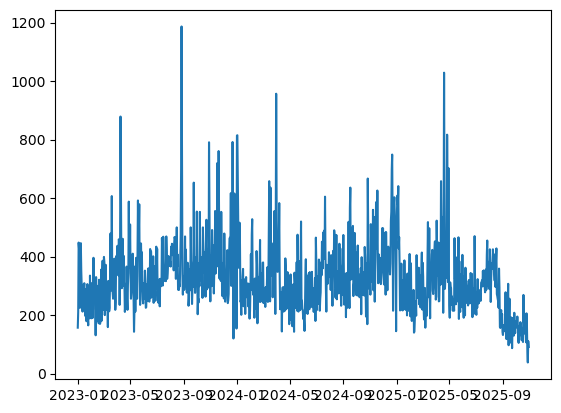

In [17]:
plt.plot(df_agregado['FECHA_CORRIDA'],df_agregado['VENTABOL_DIARIA'])
plt.show()

In [18]:
df_agregado,scaler_Y = Get_TrainigFrame(df_agregado)

In [19]:
df_agregado

,FECHA_CORRIDA,VENTABOL_DIARIA,PROP_HoraSalidaOrigenCorrida_0,PROP_HoraSalidaOrigenCorrida_1,PROP_HoraSalidaOrigenCorrida_10,PROP_HoraSalidaOrigenCorrida_11,PROP_HoraSalidaOrigenCorrida_12,PROP_HoraSalidaOrigenCorrida_13,PROP_HoraSalidaOrigenCorrida_14,PROP_HoraSalidaOrigenCorrida_15,...,HORAS_ANTICIPACION,DIF_TARIF,VENTA,Anio,Buen_Dia,Buen_Mes,DiaSemana_sin,DiaSemana_cos,Mes_sin,Mes_cos
0,2023-01-01,0.103568,0.000000,0.000000,0.0,0.000000,0.000000,0.169492,0.000000,0.039548,...,0.000000,0.629972,0.418666,0.0,1,1,0.099031,8.019377e-01,0.750000,0.933013
1,2023-01-02,0.150566,0.094118,0.113725,0.0,0.007843,0.133333,0.039216,0.113725,0.035294,...,0.014840,0.522728,0.382594,0.0,1,1,0.500000,1.000000e+00,0.750000,0.933013
2,2023-01-03,0.356832,0.000000,0.053131,0.0,0.011385,0.000000,0.060721,0.041746,0.227704,...,0.022922,0.563842,0.384253,0.0,0,1,0.900969,8.019377e-01,0.750000,0.933013
3,2023-01-04,0.337685,0.000000,0.075435,0.0,0.052224,0.000000,0.029014,0.069632,0.054159,...,0.018173,0.492216,0.317901,0.0,0,1,1.000000,3.568959e-01,0.750000,0.933013
4,2023-01-05,0.204526,0.000000,0.064725,0.0,0.051780,0.038835,0.000000,0.100324,0.058252,...,0.017643,0.610261,0.327758,0.0,0,1,0.722521,5.551115e-17,0.750000,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,2025-10-27,0.108790,0.000000,0.000000,0.0,0.251282,0.000000,0.000000,0.000000,0.000000,...,0.409074,0.778639,0.741097,1.0,1,0,0.500000,1.000000e+00,0.066987,0.750000
1031,2025-10-28,0.033072,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004037,0.980623,0.776676,1.0,0,0,0.900969,8.019377e-01,0.066987,0.750000
1032,2025-10-29,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.089201,0.651004,0.840842,1.0,0,0,1.000000,3.568959e-01,0.066987,0.750000
1033,2025-10-30,0.063533,0.000000,0.000000,0.0,0.203008,0.000000,0.000000,0.000000,0.000000,...,0.076237,0.588788,0.714910,1.0,0,0,0.722521,5.551115e-17,0.066987,0.750000


In [20]:
#df_agregado.to_csv('Data4LSTM.csv')

In [21]:
data_scaled = df_agregado[df_agregado.columns[1:]].values

In [22]:
def crear_secuencias(data, target_col_index, lookback_period):
    """
    Crea las secuencias de entrada (X) y salida (Y) para la LSTM.
    Compatible cuando el target está al inicio del array.
    """
    X, Y = [], []
    for i in range(len(data) - lookback_period):
        # X: Ventana de lookback_period días con todas las columnas excepto el target
        X.append(data[i:(i + lookback_period), 1:])  # <- CORREGIDO
        
        # Y: El TARGET del día siguiente (columna 0)
        Y.append(data[i + lookback_period, target_col_index]) 
    
    return np.array(X), np.array(Y)

In [23]:
LOOKBACK_DAYS = 30 # Usando un lookback de 30 días como ejemplo
target_index= 0
X_sequences, Y_targets = crear_secuencias(data_scaled, target_index, LOOKBACK_DAYS)

# El array X_sequences ya está en el formato tridimensional requerido: (Muestras, 30, Features)
print(f"Dimensiones de X (Input LSTM): {X_sequences.shape}")
print(f"Dimensiones de Y (Target LSTM): {Y_targets.shape}")

Dimensiones de X (Input LSTM): (1005, 30, 54)
Dimensiones de Y (Target LSTM): (1005,)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Definición de Parámetros de Entrada ---
# NOTA: Debes usar las dimensiones de tus arrays X_sequences y Y_targets
LOOKBACK_DAYS = X_sequences.shape[1]  
NUM_FEATURES = X_sequences.shape[2]   

# ----------------------------------------------------------------------
# 2. Construcción del Modelo Secuencial
# ----------------------------------------------------------------------

model = Sequential()

# Primera Capa LSTM (Capa principal de aprendizaje secuencial)
# 'return_sequences=True' es OBLIGATORIO si vas a apilar otra capa LSTM
# Usa un número de unidades (neuronas) adecuado, ej., 64 a 128
model.add(LSTM(units=100, 
               activation='tanh', 
               return_sequences=True,
               input_shape=(LOOKBACK_DAYS, NUM_FEATURES)))

# Capa de Regularización (Dropout)
# Ayuda a prevenir el sobreajuste (overfitting)
model.add(Dropout(0.3))

# Segunda Capa LSTM (Capaz de aprender patrones temporales más complejos)
# 'return_sequences=False' porque esta es la última capa LSTM antes de la salida
model.add(LSTM(units=100, activation='tanh', return_sequences=False))

# Otra Capa de Regularización
model.add(Dropout(0.3))

# Capa de Salida (Dense)
# units=1 porque solo estamos prediciendo UN valor (VENTABOL_DIARIA)
# activation='linear' es estándar para problemas de regresión (pronóstico de valores)
model.add(Dense(units=1, activation='linear'))

# ----------------------------------------------------------------------
# 3. Compilación del Modelo
# ----------------------------------------------------------------------

# Optimizer: Adam es el más común y robusto.
# Loss: Mean Squared Error (MSE) es la función de pérdida estándar para la regresión.
# Metrics: Root Mean Squared Error (RMSE) es más interpretable que MSE (está en las unidades del target escalado).
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Muestra el resumen de la arquitectura
print("✅ Arquitectura del modelo LSTM construida:")
model.summary()

✅ Arquitectura del modelo LSTM construida:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 100)             │          62,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,501 (556.64 KB)

 Trainable params: 142,501 (556.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ----------------------------------------------------------------------
# 4. Separación de Datos (Ejemplo: 80% Entrenamiento, 20% Validación)
# ----------------------------------------------------------------------
split_ratio = 0.8
split_point = int(split_ratio * len(X_sequences))

X_train = X_sequences[:split_point]
Y_train = Y_targets[:split_point]

X_val = X_sequences[split_point:]
Y_val = Y_targets[split_point:]

# ----------------------------------------------------------------------
# 5. Entrenamiento
# ----------------------------------------------------------------------

# Hyperparámetros
EPOCHS = 200    # Número de pasadas completas por el dataset
BATCH_SIZE = 32 # Número de muestras procesadas antes de actualizar los pesos

print("\n🚀 Iniciando el entrenamiento...")

history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    verbose=0,
    shuffle=False # CRUCIAL: No mezcles datos de series de tiempo
)


🚀 Iniciando el entrenamiento...



📈 Generando predicciones sobre el conjunto de validación...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step

📊 Resultados de evaluación en el conjunto de validación (escala original):
RMSE: 162.4240
MAE : 130.9681


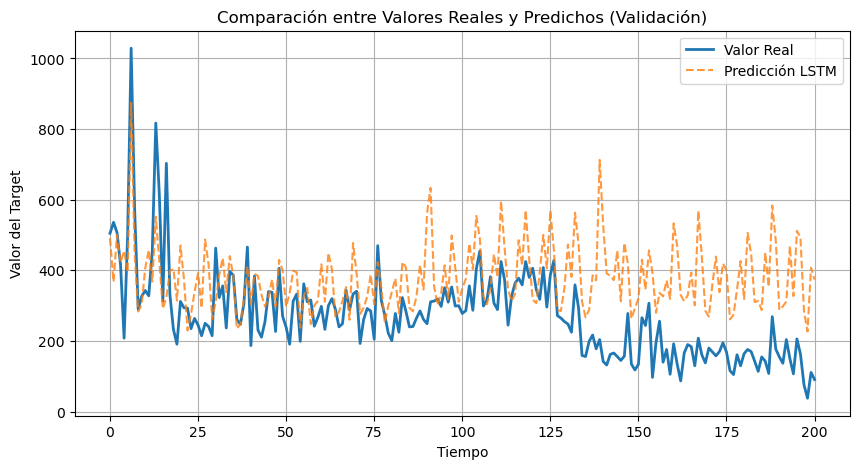

In [26]:
# ----------------------------------------------------------------------
# 6. Predicciones y Evaluación (con inversión de escala)
# ----------------------------------------------------------------------

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

print("\n📈 Generando predicciones sobre el conjunto de validación...")

# --- Predicciones ---
Y_pred_scaled = model.predict(X_val)

# Aplanar (por seguridad)
Y_pred_scaled = Y_pred_scaled.flatten()
Y_val_scaled  = Y_val.flatten()

# --- Inversión de la escala ---
# Usa tu scaler del target: 'scaler_Y'
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_val_original = scaler_Y.inverse_transform(Y_val_scaled.reshape(-1, 1)).flatten()

# --- Cálculo de métricas ---
rmse = np.sqrt(mean_squared_error(Y_val_original, Y_pred))
mae  = mean_absolute_error(Y_val_original, Y_pred)

print("\n📊 Resultados de evaluación en el conjunto de validación (escala original):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# ----------------------------------------------------------------------
# 7. Comparación visual
# ----------------------------------------------------------------------

plt.figure(figsize=(10,5))
plt.plot(Y_val_original, label='Valor Real', linewidth=2)
plt.plot(Y_pred, label='Predicción LSTM', linestyle='--', alpha=0.8)
plt.title('Comparación entre Valores Reales y Predichos (Validación)')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Target')
plt.legend()
plt.grid(True)
plt.show()
